In [1]:
from lib.utils import *
from lib.models import *
from lib.ekyn import *
from lib.env import *
from lib.datasets import *
class Gandalf(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Frodo(n_features=5000,device=DEVICE).to(DEVICE)
        self.lstm = nn.LSTM(16,32,bidirectional=True)
        self.fc1 = nn.Linear(64,3)
    def forward(self,x_2d,classification=True):
        x_2d = x_2d.view(-1,9,1,5000)
        x = torch.Tensor().to(DEVICE)
        for t in range(x_2d.size(1)):
            xi = self.encoder(x_2d[:,t,:,:],classification=False)
            x = torch.cat([x,xi.unsqueeze(0)],dim=0)
        out,_ = self.lstm(x)
        if(classification):
            x = self.fc1(out[-1])
        else:
            x = out[-1]
        return x
model = Gandalf()

In [7]:
FOLD = 10
folds = get_leave_one_out_cv_ids_for_ekyn()
_,test_ids = folds[FOLD]
print(test_ids)
X,y = load_eeg_label_pairs(ids=test_ids)
testloader = DataLoader(Windowset(X,y),batch_size=32,shuffle=False)
criterion = torch.nn.CrossEntropyLoss()
model = Gandalf()
model.load_state_dict(torch.load(f=f'../models/gandalfs/gandalf_{FOLD}/best_model.pt',map_location='cpu'))
model.to(DEVICE)
loss,report,y_true,y_pred,y_logits = evaluate(testloader,model,criterion,DEVICE)

['D1-0']


100%|██████████| 540/540 [00:39<00:00, 13.72it/s]


              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87      1391
         1.0       0.96      0.96      0.96      7890
         2.0       0.94      0.95      0.95      7999

    accuracy                           0.95     17280
   macro avg       0.93      0.92      0.93     17280
weighted avg       0.95      0.95      0.95     17280

0.13717000708202798


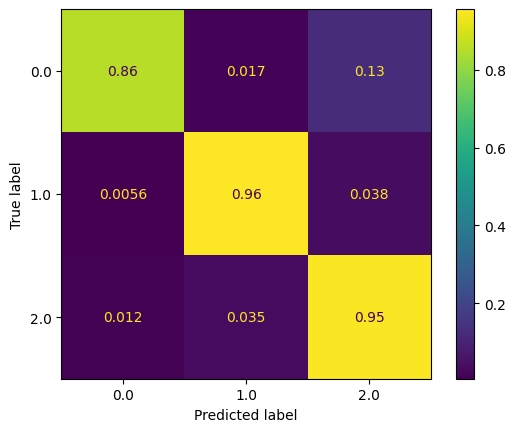

In [5]:
from sklearn.metrics import ConfusionMatrixDisplay,classification_report

ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='true')
print(classification_report(y_true,y_pred))
print(loss)

[]

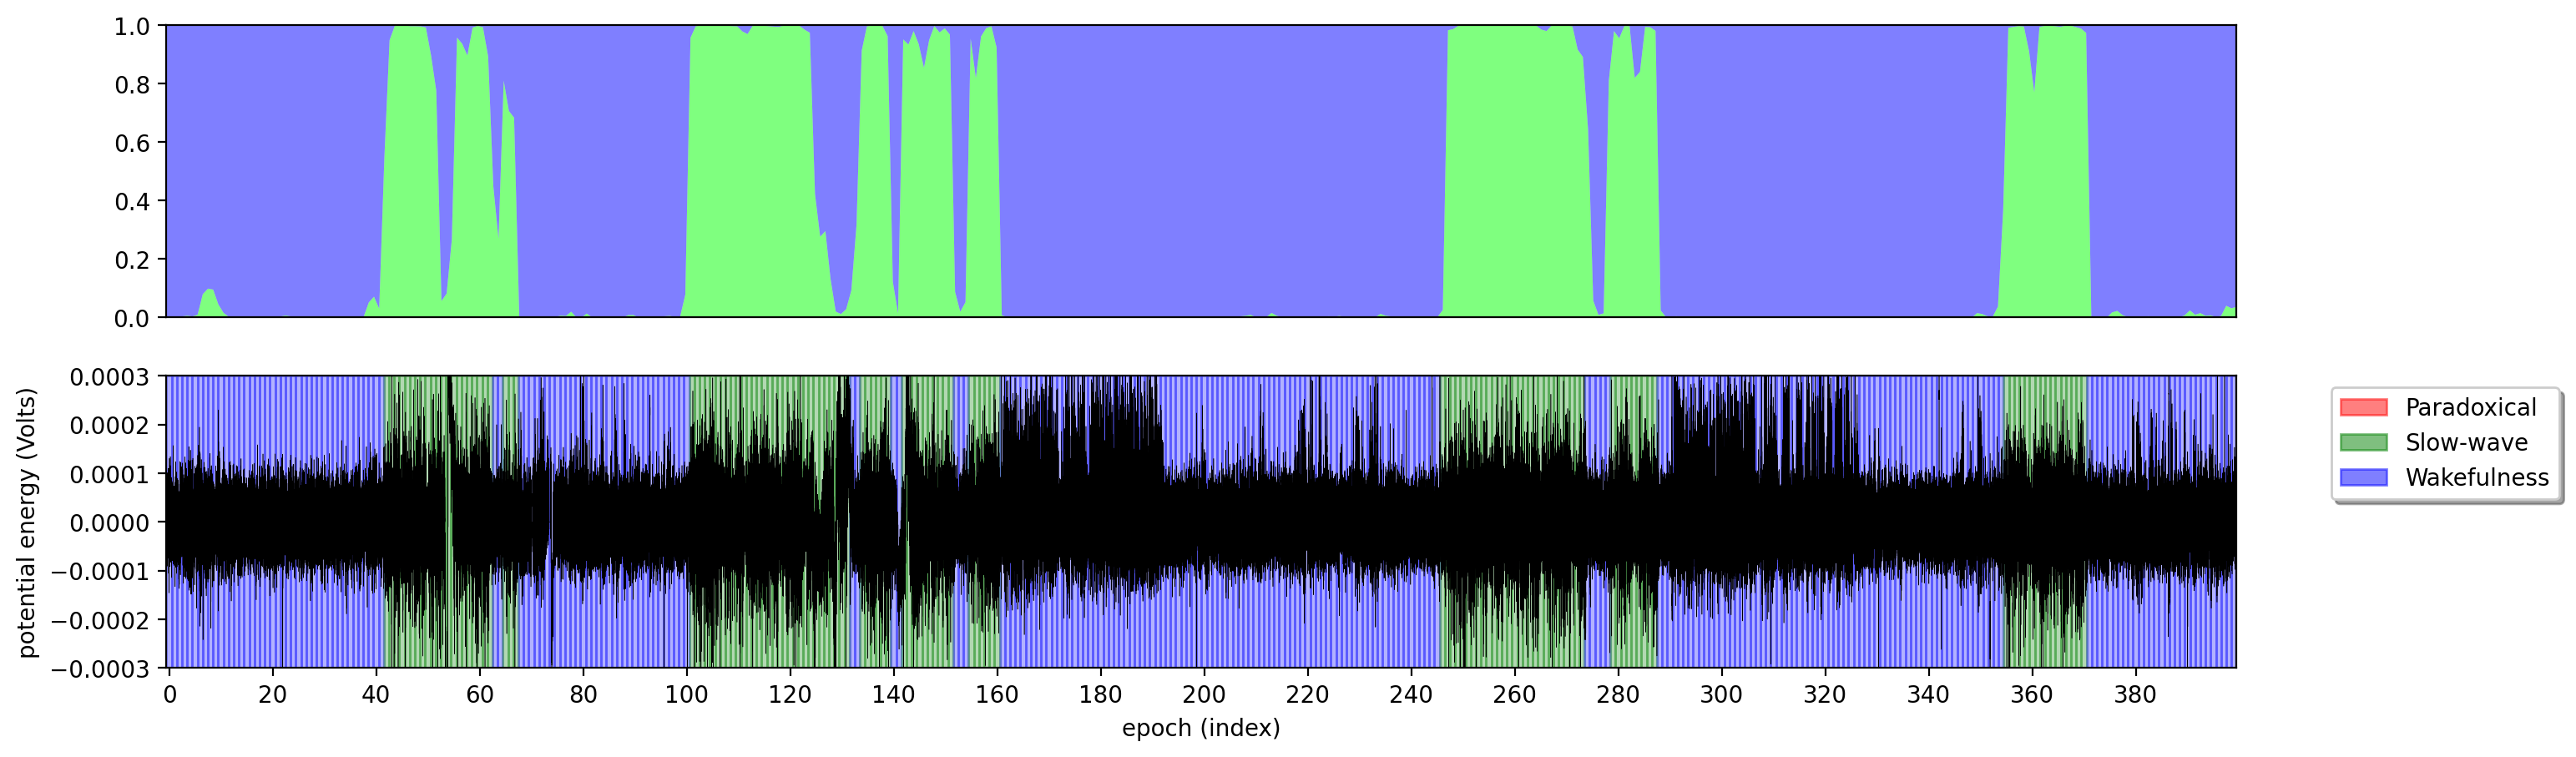

In [6]:
import matplotlib.patches as patches
start = 700
duration = 400
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(16,5),dpi=200)

ax[1].plot(X[start:start+duration].flatten(),'black',linewidth=.2)
colors = ['red','green','blue']
epochs = []
for i in range(duration):
    stage = int(y.argmax(axis=1)[start+i])
    ax[1].fill_between([i*5000, (i+1)*5000], y1=-.0003, y2=.0003, color=colors[stage], alpha=0.3)
    epochs.append(i*5000+2500)

red_patch = patches.Patch(color='red', alpha=0.5, label='Paradoxical')
green_patch = patches.Patch(color='green', alpha=0.5, label='Slow-wave')
blue_patch = patches.Patch(color='blue', alpha=0.5, label='Wakefulness')
ax[1].set_ylim([-.0003,.0003])
ax[1].margins(0,0)
plt.legend(handles=[red_patch, green_patch,blue_patch],loc='upper left', bbox_to_anchor=(1.04, 1),
        fancybox=True, shadow=True, ncol=1)
plt.xlabel('epoch (index)')
ax[1].set_ylabel('potential energy (Volts)')
ax[1].set_xticks(epochs[::int(duration/20)],range(duration)[::int(duration/20)]);

ax[0].stackplot(torch.linspace(0,duration-1,duration),y_logits[start:start+duration,0],y_logits[start:start+duration,1],y_logits[start:start+duration,2],colors=['#FF000080','#00FF0080','#0000FF80'])
ax[0].margins(0,0)
ax[0].set_xticks([])

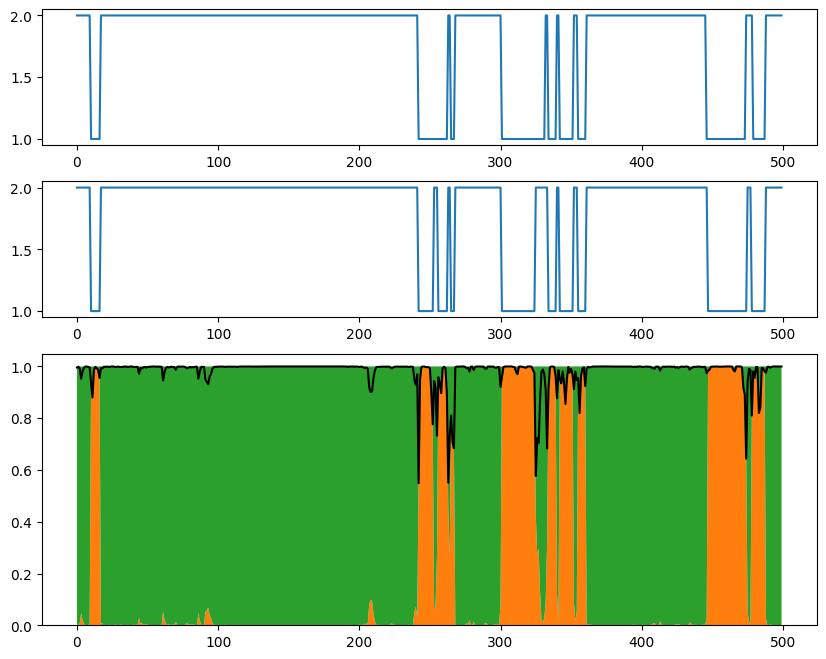

In [30]:
confidences = []
idx = y_logits.argmax(axis=1)
for logit,idx in zip(y_logits,idx):
    confidences.append(logit[idx].item())
fig,axes = plt.subplots(ncols=1,nrows=3,figsize=(10,8),dpi=100,gridspec_kw={'height_ratios': [1,1,2]})
upper = 1000
axes[2].stackplot(torch.arange(len(y_logits[500:upper])),y_logits[500:upper].T)
axes[2].plot(confidences[500:upper],'black')
axes[0].plot(y_true[500:upper])
axes[1].plot(y_pred[500:upper])